### Scenario:
A company is testing a GPT-powered customer support bot. It generates answers to customer questions based on internal documents.

Given a sample dataset containing:

- Customer questions

- LLM-generated responses

- Expected (human-verified) responses

- Optional metadata (confidence scores, categories)

The task is to evaluate the quality of the LLM outputs, compare them to expected answers, and make recommendations based on your findings.

In [1]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
from rouge_score import rouge_scorer

In [2]:
# Load the dataset
df = pd.read_csv("llm_evaluation_data.csv")

In [3]:
df

,ID,Question,LLM_Response,Expected_Response,Category,Confidence
0,1,What is the return policy?,You can return items within 15 days of purchase.,Items may be returned within 30 days of purchase.,Policy,0.92
1,2,How do I reset my password?,Click on ‘Forgot Password’ on the login page a...,Same as LLM response,Tech,0.98
2,3,Do you offer international shipping?,We only deliver within the United States.,"Yes, we ship worldwide via DHL and FedEx.",Shipping,0.89


In [4]:
# Binary label for exact match
df['is_exact_match'] = df['LLM_Response'].str.strip().str.lower() == df['Expected_Response'].str.strip().str.lower()

In [5]:
# Evaluate Accuracy
accuracy = df['is_exact_match'].mean()
print(f"Exact Match Accuracy: {accuracy:.2f}")

Exact Match Accuracy: 0.00


In [6]:
# ROUGE Evaluation for open-ended questions
scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
df['rougeL'] = df.apply(lambda row: scorer.score(row['Expected_Response'], row['LLM_Response'])['rougeL'].fmeasure, axis=1)

In [7]:
print("Average ROUGE-L Score:", df['rougeL'].mean())

Average ROUGE-L Score: 0.22962962962962963


In [8]:
# Flag hallucinations based on known contradiction (manual rule)
df['hallucinated'] = df['is_exact_match'] == False

In [9]:
# Category-level summary
category_stats = df.groupby('Category').agg({
    'is_exact_match': 'mean',
    'hallucinated': 'mean',
    'rougeL': 'mean'
}).rename(columns={
    'is_exact_match': 'ExactMatchRate',
    'hallucinated': 'HallucinationRate',
    'rougeL': 'AvgRougeL'
})

print("\nCategory-Level Evaluation Summary:\n", category_stats)


Category-Level Evaluation Summary:
           ExactMatchRate  HallucinationRate  AvgRougeL
Category                                              
Policy               0.0                1.0   0.555556
Shipping             0.0                1.0   0.133333
Tech                 0.0                1.0   0.000000


In [10]:
from bert_score import score

# Extract reference and hypothesis sentences
candidates = df['LLM_Response'].tolist()
references = df['Expected_Response'].tolist()

# Compute BERTScore (you can change lang or model_type if needed)
P, R, F1 = score(candidates, references, lang="en", verbose=True)

# Store F1 scores in dataframe
df['BERTScore_F1'] = F1.tolist()

# Summary
print(f"Average BERTScore F1: {df['BERTScore_F1'].mean():.4f}")

# Compare hallucinated vs non-hallucinated examples
print(df[['Question', 'LLM_Response', 'Expected_Response', 'BERTScore_F1', 'hallucinated']])


2025-06-26 17:32:27.121618: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750955548.267324   23092 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750955548.536495   23092 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1750955551.035528   23092 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750955551.035579   23092 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1750955551.035588   23092 computation_placer.cc:177] computation placer alr

calculating scores...
computing bert embedding.


  0%|          | 0/1 [00:00<?, ?it/s]

computing greedy matching.


  0%|          | 0/1 [00:00<?, ?it/s]

done in 28.77 seconds, 0.10 sentences/sec
Average BERTScore F1: 0.8816
                               Question  \
0            What is the return policy?   
1           How do I reset my password?   
2  Do you offer international shipping?   

                                        LLM_Response  \
0   You can return items within 15 days of purchase.   
1  Click on ‘Forgot Password’ on the login page a...   
2          We only deliver within the United States.   

                                   Expected_Response  BERTScore_F1  \
0  Items may be returned within 30 days of purchase.      0.943109   
1                               Same as LLM response      0.817941   
2          Yes, we ship worldwide via DHL and FedEx.      0.883648   

   hallucinated  
0          True  
1          True  
2          True  


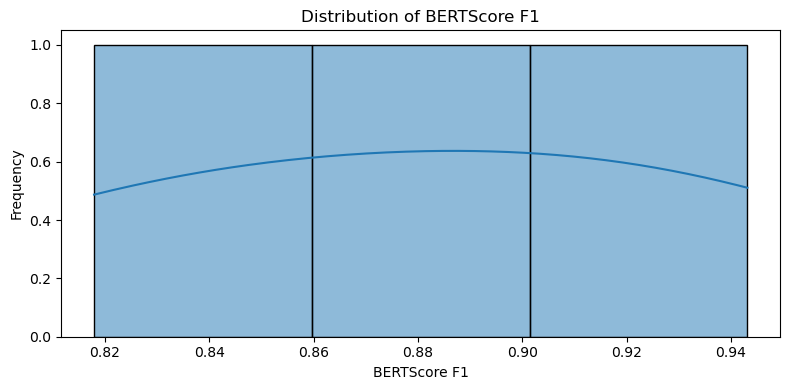

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
sns.histplot(df['BERTScore_F1'], kde=True)
plt.title('Distribution of BERTScore F1')
plt.xlabel('BERTScore F1')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()
